In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'cencoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.cencoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,HSU/CeNCOOS,Yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables
1,Humboldt,HBXC1,Humboldt Bay: Chevron Dock,Chevron Dock Pier Station,40.78,-124.2,fixed pier,2003,y,HSU/CeNCOOS,yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(2m), sea_water_salinity(...",NaN
2,Humboldt,N/A not real-time,Humboldt Bay: South Bay,Humboldt Bay South Bay Station,40.43,-124.13,fixed pier,2006-08-01 00:00:00,y,HSU/CeNCOOS,Yp,HSU,Academic,HSU,HSU,"sea_water_temperature(2m), sea_water_salinity(...",NaN
3,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/HSU,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/HSU,"sea_water_temperature(2.4m), sea_water_salini...",NaN
4,HSU IFCB,N/A not yet operational,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,NaN,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN
5,Kibesilla Hill,N/A not real-time,Kibisilla Hill,Kibesilla Hill Intertidal Station,39.6,-123.79,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN
6,Bodega Head,N/A not real-time,Bodega Head,Bodega Head intertidal station,38.32,-123.07,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN
7,Bodega,BDXC1,Bodega,Horeshoe cove BML Seawater Intake Station,38.32,-123.07,fixed intake,2003,y,UC Davis/CeNCOOS,yp,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature(2.9m), sea_water_salinit...",NaN
8,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,NaN,o,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN
9,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
df_wf = df[df['Station ID'] == 'ioos:station:TCOON:076']

# for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
search_for = df_wf['Station ID'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

try:
    resp = pd.read_csv(search_url)
    print(resp['Station ID'])
except:
    pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

for station in df['Station ID'].astype(str):
    
    if station == "nan":
        print("punting with station id = nan\n")
        not_found.append(station)
        continue
    
    try:
        search_url = e.get_search_url(search_for=station, response="csv")
        resp = pd.read_csv(search_url)
        print("Found \"%s\": %s" % (station,resp['Dataset ID'].values.tolist()))
        
        found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        #not_found.append(station)
#        pass
        print('no dataset matching \"%s\"' % station)
        station_long_name = df.loc[df['Station ID'] == station,'Station Long Name'].values.tolist()[0]
        
        if station_long_name == "nan":
                print("punting with statopm long name = nan\n")
                not_found.append(station)
                continue
                
        try:
            print('searching \"station long name\" = \"%s\"' % station_long_name)
            search_url = e.get_search_url(search_for=station_long_name, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (station_long_name,resp['Dataset ID'].values.tolist()))
            
            found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            station_wmo = str(df.loc[df['Station ID'] == station,'WMO ID or NWS/CMAN ID'].values.tolist()[0])
            
            if station_wmo == "nan":
                print("punting with station_wmo = nan\n")
                not_found.append(station)
                continue
            
            try:
                print('searching \"WMO ID\" = \"%s\"' % station_wmo)
                search_url = e.get_search_url(search_for=station_wmo, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (station_wmo,resp['Dataset ID'].values.tolist()))
                
                found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:    
                not_found.append(station)
        
    print("\n")

Found "Trinidad": ['edu_utah_mesowest_e1752', 'noaa_esrl_thd', 'uw130_20150309t2005', 'uw130_20170605t1834', 'uw130_20181107t0000', 'uw157_20141116t2118', 'uw157_20150917t1833', 'uw157_20161021t1807', 'uw157_20180417t1832', 'uw157_20190916t0000', 'uw157_20200917t0000', 'uw646_20190409t0000', 'uw646_20210816t0000', 'gov_usgs_waterdata_11481200', 'edu_humboldt_tdp']


Found "Humboldt": ['edu_humboldt_hbc', 'edu_ucsd_cdip_128', 'edu_ucsd_cdip_168', 'miscwebcam_127', 'humboldt-bay-burkeolator', 'noaa_nos_co_ops_9418767', 'noaa_nos_co_ops_9418768', 'edu_humboldt_humboldt', 'edu_humboldt_tdp', 'wiyot_tribe_indianisland']


Found "Humboldt": ['edu_humboldt_hbc', 'edu_ucsd_cdip_128', 'edu_ucsd_cdip_168', 'miscwebcam_127', 'humboldt-bay-burkeolator', 'noaa_nos_co_ops_9418767', 'noaa_nos_co_ops_9418768', 'edu_humboldt_humboldt', 'edu_humboldt_tdp', 'wiyot_tribe_indianisland']


Found "Tuluwat Island": ['wiyot_tribe_indianisland']


no dataset matching "HSU IFCB"
searching "station long name" = "

Print the stations that we couldn't find.

In [7]:
len(not_found)

4

In [8]:
len(found)

20

In [9]:
df.loc[df['Station ID'].isna()]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


In [10]:
df[df['Station ID'].isin(not_found)]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
4,HSU IFCB,N/A not yet operational,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,NaN,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN
8,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,NaN,o,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN
15,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN
17,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN


In [11]:
#found.pop('HTLPWES')
found

{'Trinidad': {'Dataset ID': ['edu_utah_mesowest_e1752',
   'noaa_esrl_thd',
   'uw130_20150309t2005',
   'uw130_20170605t1834',
   'uw130_20181107t0000',
   'uw157_20141116t2118',
   'uw157_20150917t1833',
   'uw157_20161021t1807',
   'uw157_20180417t1832',
   'uw157_20190916t0000',
   'uw157_20200917t0000',
   'uw646_20190409t0000',
   'uw646_20210816t0000',
   'gov_usgs_waterdata_11481200',
   'edu_humboldt_tdp']},
 'Humboldt': {'Dataset ID': ['edu_humboldt_hbc',
   'edu_ucsd_cdip_128',
   'edu_ucsd_cdip_168',
   'miscwebcam_127',
   'humboldt-bay-burkeolator',
   'noaa_nos_co_ops_9418767',
   'noaa_nos_co_ops_9418768',
   'edu_humboldt_humboldt',
   'edu_humboldt_tdp',
   'wiyot_tribe_indianisland']},
 'Tuluwat Island': {'Dataset ID': ['wiyot_tribe_indianisland']},
 'Kibesilla Hill': {'Dataset ID': ['san_francisco_state_universit_kibesillah_hill_intertidal_shore_station']},
 'Bodega Head': {'Dataset ID': ['san_francisco_state_universit_bodega_head_intertidal_shore_station',
   'bode

Check if the dataset has coverage for CY 2021

In [12]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Datasets without coverage for 2021:
{'Kibesilla Hill', 'Tuluwat Island', 'Monterey Wharf'}


Show me the inventory metadata about the invalid stations:

In [13]:
bad_stations = df.loc[(df['Station ID'].isin(non_2021_datasets)) | df['Station ID'].isin(not_found)]

df['erddap_not_avail'] = df['Station ID'].isin(bad_stations['Station ID'])

In [14]:
df['erddap_not_avail']

0     False
1     False
2     False
3      True
4      True
5      True
6     False
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15     True
16    False
17     True
18    False
19    False
20     True
21    False
22    False
23    False
24    False
Name: erddap_not_avail, dtype: bool

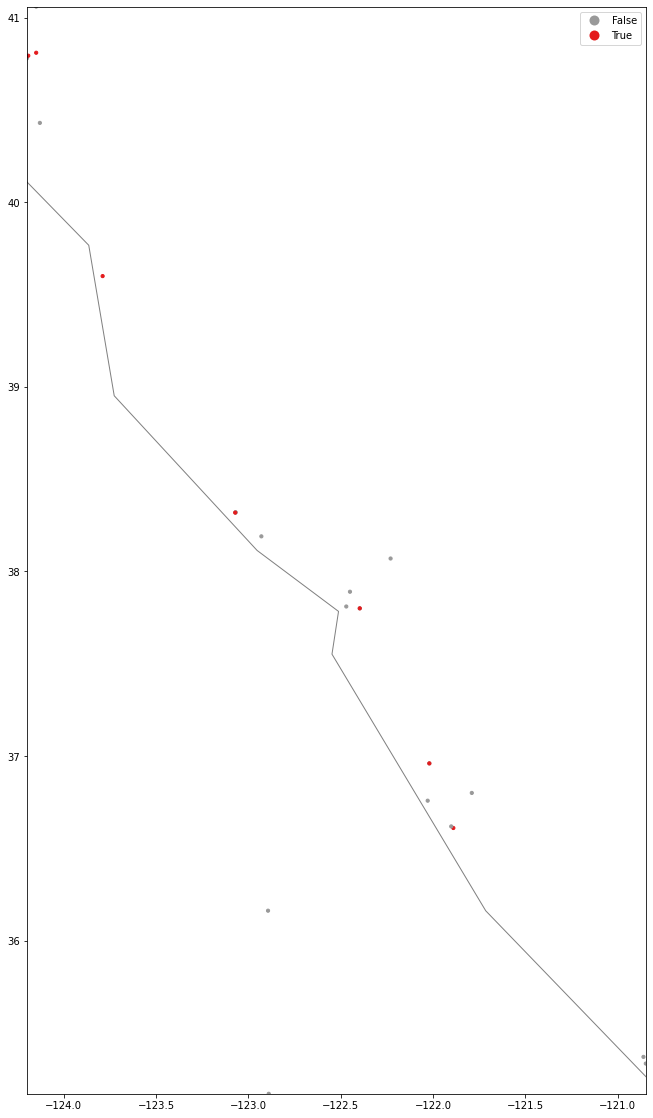

In [15]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_not_avail', 
         categorical=True, 
         cmap = 'Set1_r',
         markersize=10, 
         legend=True,
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [16]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore('erddap_not_avail',cmap = 'Set1_r',)

In [17]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_not_avail,geometry


In [18]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

Tuluwat Island
URL broken: Tuluwat Island
3    Tuluwat Island
Name: Station ID, dtype: object
HSU IFCB
URL broken: HSU IFCB
4    HSU IFCB
Name: Station ID, dtype: object
Kibesilla Hill Intertidal Station
URL broken: Kibesilla Hill Intertidal Station
5    Kibesilla Hill
Name: Station ID, dtype: object
Bodega IFCB163
URL broken: Bodega IFCB163
8    IFCB163
Name: Station ID, dtype: object
San Francisco Pier 17 IFCB
URL broken: San Francisco Pier 17 IFCB
15    IFCB San Francisco Pier 17
Name: Station ID, dtype: object
Santa Cruz Municipal Wharf IFCB
URL broken: Santa Cruz Municipal Wharf IFCB
17    IFCB Santa Cruz
Name: Station ID, dtype: object
Monterey: Municipal Wharf II
URL broken: Monterey: Municipal Wharf II
20    Monterey Wharf
Name: Station ID, dtype: object


In [19]:
df.shape

(25, 19)

In [20]:
gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ','')

3                        Tuluwat Island
4                              HSU IFCB
5     Kibesilla Hill Intertidal Station
8                        Bodega IFCB163
15           San Francisco Pier 17 IFCB
17      Santa Cruz Municipal Wharf IFCB
20         Monterey: Municipal Wharf II
Name: Station Description, dtype: object

In [21]:
gdf_final.loc[gdf_final['Station Description'].str.contains('http://ndbc.noaa.gov/station_page.php?station=42365',regex=False),'Station ID']

Series([], Name: Station ID, dtype: object)

In [22]:
gdf_final['Station Description'].astype(str)

0                        Trinidad Shore Station
1                     Chevron Dock Pier Station
2                Humboldt Bay South Bay Station
3                                Tuluwat Island
4                                      HSU IFCB
5             Kibesilla Hill Intertidal Station
6                Bodega Head intertidal station
7     Horeshoe cove BML Seawater Intake Station
8                                Bodega IFCB163
9                              Tomales Bay Buoy
10                          Hog Island Hatchery
11                    Carquinez at Cal Maritime
12                                 Tiburon Pier
13                                   Fort Point
14                                Exploritorium
15                   San Francisco Pier 17 IFCB
16                             Santa Cruz Wharf
17              Santa Cruz Municipal Wharf IFCB
18                 Moss Landing Seawater Intake
19                                           M1
20                 Monterey: Municipal W